In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from functionalfourier.layers import *
from functionalfourier.layers import GaborReductionBlock
# from fxlayers.layers import GaborGammaFourier
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

In [113]:
from tensorflow.keras.datasets import mnist, cifar10

In [258]:
config = {
    "DATASET": "cifar10", # mnist / cifar10
    "BATCH_SIZE": 64,
    "EPOCHS": 50,
    "LEARNING_RATE": 3e-3,
    "SEED": 42,

    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,

    "USE_BIAS": False,
    "GAP": False,
    "SAME_REAL_IMAG": True,
    # "N_SCALES": 4,
    # "N_ORIENTATIONS": 16,

    "N_GABORS": 64,
    "REDUCTION": 0.5,
    "A_GABOR": True,
    # "A_GDNSPATIOFREQORIENT": True,

    "N_BLOCKS": 1,

    "USE_DNGAUSS": False,
    "USE_DNCONV": False,
    "DN_KERNEL_SIZE": 5,
}
config = ConfigDict(config)
config

A_GABOR: true
BATCH_SIZE: 64
DATASET: cifar10
DN_KERNEL_SIZE: 5
EPOCHS: 50
GAP: false
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_BLOCKS: 1
N_GABORS: 64
REDUCTION: 0.5
SAME_REAL_IMAG: true
SEED: 42
USE_BIAS: false
USE_DNCONV: false
USE_DNGAUSS: false
ZERO_MEAN: true

In [259]:
wandb.init(project="FourierNN",
           name="GaborFourier_InvertingNL",
           job_type="training",
           config=config,
           mode="disabled",
           )
config = config
config

A_GABOR: true
BATCH_SIZE: 64
DATASET: cifar10
DN_KERNEL_SIZE: 5
EPOCHS: 50
GAP: false
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_BLOCKS: 1
N_GABORS: 64
REDUCTION: 0.5
SAME_REAL_IMAG: true
SEED: 42
USE_BIAS: false
USE_DNCONV: false
USE_DNGAUSS: false
ZERO_MEAN: true

In [260]:
if config.DATASET == "cifar10":
    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    X_train = X_train/255.
    X_test = X_test/255.
    Y_train = Y_train.astype(np.int32)[...,0]
    Y_test = Y_test.astype(np.int32)[...,0]

elif config.DATASET == "mnist":
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = X_train[...,None]/255.
    X_test = X_test[...,None]/255.
    Y_train = Y_train.astype(np.int32)
    Y_test = Y_test.astype(np.int32)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [261]:
dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dst_val = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [262]:
dst_train_rdy = dst_train.shuffle(buffer_size=100,
                              reshuffle_each_iteration=True,
                              seed=config.SEED)\
                         .batch(config.BATCH_SIZE, drop_remainder=True)
dst_val_rdy = dst_val.batch(config.BATCH_SIZE, drop_remainder=True)

In [263]:
def obtain_fourier(inputs):
    outputs = jnp.fft.fft2(inputs, axes=(1,2)) # Assuming (B, H, W, C) we want the spatial FFT
    outputs = jnp.fft.fftshift(outputs)
    return outputs.real, outputs.imag

In [264]:
def invert_fourier(real, imag):
    """Returns the real and imaginary part separated."""
    outputs = real + 1j*imag
    outputs = jnp.fft.ifftshift(outputs)
    outputs = jnp.fft.ifft2(outputs, axes=(1,2)).real
    return outputs

In [265]:
class FourierGaborReductionReLUBlock(nn.Module):
    features: int
    reduction: float
    fs: float
    norm_energy: bool = True
    same_real_imag: bool = True
    train_A: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        ## Move input into Fourier space
        outputs_r, outputs_i = obtain_fourier(inputs)

        ## Apply Gabor + Reduction block
        outputs_r, outputs_i = GaborReductionBlock(features=self.features, reduction=self.reduction, fs=self.fs, norm_energy=self.norm_energy, same_real_imag=self.same_real_imag, train_A=self.train_A)(outputs_r, outputs_i)

        ## Invert Fourier to apply non-linearity
        outputs = invert_fourier(outputs_r, outputs_i)
        outputs = nn.relu(outputs)

        return outputs

In [266]:
class Model(nn.Module):
    n_blocks: int

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs = inputs
        for i in range(self.n_blocks):
            outputs = FourierGaborReductionReLUBlock(features=config.N_GABORS*(i+1), reduction=config.REDUCTION, fs=32*config.REDUCTION*(i+1)/config.REDUCTION, norm_energy=config.NORMALIZE_ENERGY, same_real_imag=config.SAME_REAL_IMAG, train_A=config.A_GABOR)(outputs)
    
        ## GAP & Dense for final prediction
        if config.GAP:
            outputs = reduce(outputs, "b h w c -> b c", "mean")
        else:
            outputs = rearrange(outputs, "b h w c -> b (h w c)")

        outputs = nn.Dense(features=10)(outputs)

        return outputs

In [267]:
model = Model(n_blocks=config.N_BLOCKS)
variables = model.init(random.PRNGKey(42), jnp.ones((1,*X_train[0].shape)))
state, params = variables.pop("params")

In [268]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")
    accuracy: metrics.Accuracy

In [269]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

In [270]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

In [271]:
from functools import partial

In [272]:
@partial(jax.jit, static_argnums=2)
def train_step(state, batch, return_grads=False):
    """Train for a single step."""
    img, label = batch
    def loss_fn(params):
        ## Forward pass through the model
        pred = state.apply_fn({"params": params, **state.state}, img, train=True)

        ## Calculate the distance
        loss = optax.softmax_cross_entropy_with_integer_labels(pred, label)
        
        ## Calculate pearson correlation
        return loss.mean(), pred
    
    (loss, pred), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss, logits=pred, labels=label)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    if return_grads: return state, grads
    else: return state

In [273]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, label = batch
    def loss_fn(params):
        ## Forward pass through the model
        pred = state.apply_fn({"params": params, **state.state}, img, train=True)

        ## Calculate the distance
        loss = optax.softmax_cross_entropy_with_integer_labels(pred, label)
        
        ## Calculate pearson correlation
        return loss.mean(), pred
    (loss, pred) = loss_fn(state.params)
    metrics_updates = state.metrics.single_from_model_output(loss=loss, logits=pred, labels=label)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

In [274]:
state = create_train_state(Model(n_blocks=config.N_BLOCKS), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,*X_train[0].shape))

In [275]:
if config.USE_DNGAUSS:
    params = unfreeze(state.params)
    params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"] = random.uniform(key=random.PRNGKey(config.SEED), shape=params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"].shape)
    params["GDNGaussian_1"]["GaussianLayerGamma_0"]["gamma"] = random.uniform(key=random.PRNGKey(config.SEED), shape=params["GDNGaussian_1"]["GaussianLayerGamma_0"]["gamma"].shape)
    state = state.replace(params=freeze(params))

In [276]:
jax.tree_util.tree_map(lambda x: x.shape, state.params)

FrozenDict({
    Dense_0: {
        bias: (10,),
        kernel: (16384, 10),
    },
    FourierGaborReductionReLUBlock_0: {
        GaborReductionBlock_0: {
            GaborGammaFourier_0: {
                A: (3, 64),
                freq: (64,),
                gammax: (64,),
                gammay: (64,),
                theta: (64,),
            },
        },
    },
})

In [277]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
# trainable_param_count = sum([w.size if t=="trainable" else 0 for w, t in zip(jax.tree_util.tree_leaves(state.params), jax.tree_util.tree_leaves(trainable_tree))])
param_count#, trainable_param_count

164298

In [278]:
wandb.run.summary["total_parameters"] = param_count

In [279]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [280]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

In [281]:
from functools import partial

In [282]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

2024-01-23 15:32:55.659930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [50000,32,32,3]
	 [[{{node Placeholder/_0}}]]


In [283]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [284]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [285]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 936 ms, sys: 551 ms, total: 1.49 s
Wall time: 588 ms


(64, 10)

In [286]:
%%time
s1, grads = train_step(state, batch, return_grads=True)

CPU times: user 2.29 s, sys: 138 ms, total: 2.42 s
Wall time: 1.82 s


In [287]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state, grads = train_step(state, batch, return_grads=True)
        wandb.log({f"{k}_grad": wandb.Histogram(v) for k, v in flatten_params(grads).items()}, commit=False)
        # state = compute_metrics(state=state, batch=batch)
        break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Obtain activations of last validation batch
    _, extra = forward_intermediates(state, batch[0])
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(extra["intermediates"]).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} | Acc: {metrics_history["train_accuracy"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]} | Acc: {metrics_history["val_accuracy"][-1]}')
    # break

2024-01-23 15:33:00.328756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [10000]
	 [[{{node Placeholder/_1}}]]


Epoch 0 -> [Train] Loss: 2.3073108196258545 | Acc: 0.078125 [Val] Loss: 3.6219301223754883 | Acc: 0.03125
Epoch 1 -> [Train] Loss: 2.942005157470703 | Acc: 0.171875 [Val] Loss: 2.9998083114624023 | Acc: 0.09375
Epoch 2 -> [Train] Loss: 2.5500011444091797 | Acc: 0.203125 [Val] Loss: 2.50730037689209 | Acc: 0.109375
Epoch 3 -> [Train] Loss: 2.459502696990967 | Acc: 0.109375 [Val] Loss: 2.4818718433380127 | Acc: 0.09375
Epoch 4 -> [Train] Loss: 2.5050065517425537 | Acc: 0.15625 [Val] Loss: 2.464567184448242 | Acc: 0.109375
Epoch 5 -> [Train] Loss: 2.6573567390441895 | Acc: 0.09375 [Val] Loss: 2.354085922241211 | Acc: 0.125
Epoch 6 -> [Train] Loss: 2.4532670974731445 | Acc: 0.09375 [Val] Loss: 2.3265137672424316 | Acc: 0.21875
Epoch 7 -> [Train] Loss: 2.2036314010620117 | Acc: 0.140625 [Val] Loss: 2.4606223106384277 | Acc: 0.171875
Epoch 8 -> [Train] Loss: 2.222341537475586 | Acc: 0.234375 [Val] Loss: 2.6055972576141357 | Acc: 0.09375
Epoch 9 -> [Train] Loss: 2.2275891304016113 | Acc: 0.25

In [288]:
kernel_r = GaborGammaFourier(features=64, fs=32).return_kernel(state.params["FourierGaborReductionReLUBlock_0"]["GaborReductionBlock_0"]["GaborGammaFourier_0"], c_in=3, kernel_shape=(32,32))
print(kernel_r.shape)
if not config.SAME_REAL_IMAG: 
    kernel_i = GaborGammaFourier(features=64, fs=32).return_kernel(state.params["GaborGammaFourier_1"], c_in=3, kernel_shape=(32,32))
    print(kernel_i.shape)

(32, 32, 64)


In [289]:
import matplotlib.pyplot as plt

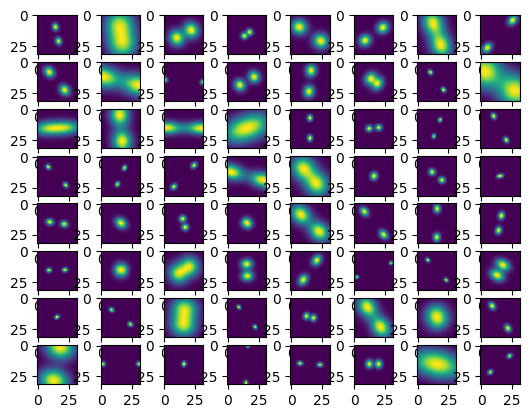

In [290]:
fig, axes = plt.subplots(8,8)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(kernel_r[...,i])
plt.show()

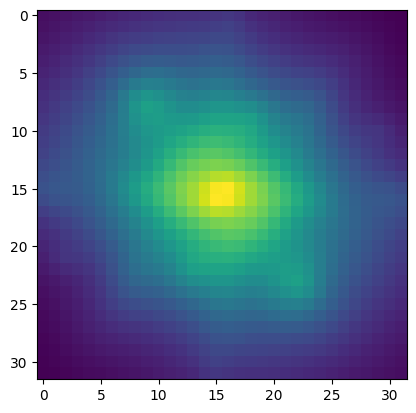

In [291]:
plt.imshow(kernel_r.sum(axis=-1))
plt.show()

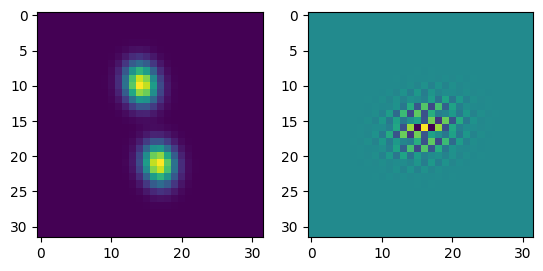

In [292]:
k = kernel_r[...,0]#+1j*kernel_r[...,0]
fig, axes = plt.subplots(1,2)
axes[0].imshow(k)
axes[1].imshow(jnp.fft.ifftshift(jnp.fft.ifft2((k))).real)
plt.show()

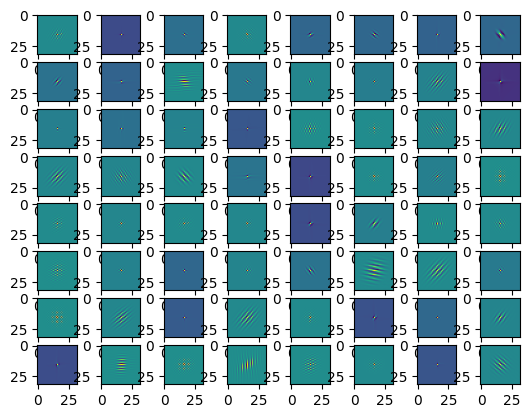

In [293]:
fig, axes = plt.subplots(8,8)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.fft.ifftshift(jnp.fft.ifft2(kernel_r[...,i])).real)
plt.show()

In [294]:
if not config.SAME_REAL_IMAG:
    fig, axes = plt.subplots(8,8)
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(kernel_i[...,i])
    plt.show()
    
    plt.imshow(kernel_i.sum(axis=-1))
    plt.show()

In [295]:
class Model(nn.Module):
    n_blocks: int

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs = inputs
        for _ in range(self.n_blocks):
            outputs = FourierGaborReductionReLUBlock(features=config.N_GABORS, reduction=config.REDUCTION, fs=32, norm_energy=config.NORMALIZE_ENERGY, same_real_imag=config.SAME_REAL_IMAG, train_A=config.A_GABOR)(outputs)
    
        # ## GAP & Dense for final prediction
        # if config.GAP:
        #     outputs = reduce(outputs, "b h w c -> b c", "mean")
        # else:
        #     outputs = rearrange(outputs, "b h w c -> b (h w c)")

        # outputs = nn.Dense(features=10)(outputs)

        return outputs

In [296]:
pred = Model(config.N_BLOCKS).apply({"params": state.params, **state.state}, batch[0])
pred.shape

(64, 16, 16, 64)

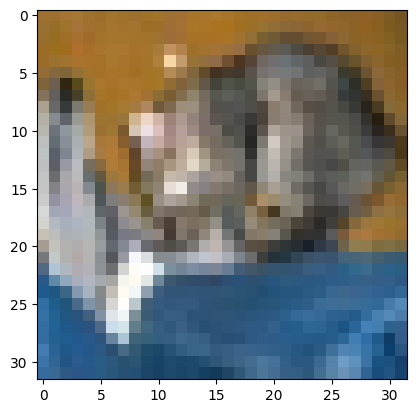

In [297]:
plt.imshow(batch[0][0])

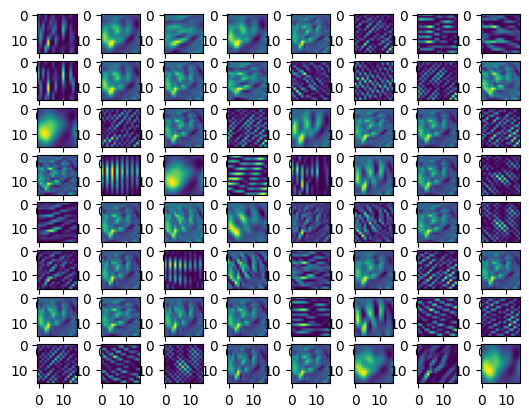

In [298]:
fig, axes = plt.subplots(8,8)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(pred[0,...,i])
plt.show()